In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
#name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

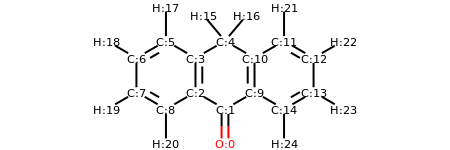

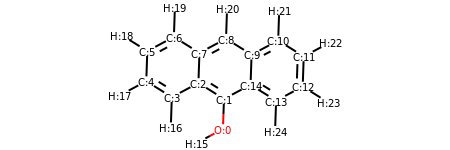

In [3]:
neutromeratio.display_mol(mols['t1'])
neutromeratio.display_mol(mols['t2'])

In [4]:
# extract hydrogen donor idx and hydrogen idx for from_mol
platform = 'cpu'
device = torch.device(platform)
ani_input['box_length'] = 3.0 * unit.nanometer
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atom=-1, ani_input=ani_input)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling

energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['ligand_atoms'],
                                          platform = platform,
                                          tautomer_transformation = {})

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['ligand_atoms'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)


n_steps = 5000
x0 = np.array(ani_input['ligand_coords']) * unit.angstrom
equilibrium_samples = langevin.run_dynamics(x0, n_steps)

TypeError: __init__() missing 1 required positional argument: 'device'

In [ ]:
torch.tensor(([1,2,3], [1,2,3]))

In [ ]:
# extract hydrogen donor idx and hydrogen idx for from_mol
tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atom=tautomer_transformation['hydrogen_idx'])
model = model.to(device)
torch.set_num_threads(2)

In [ ]:
# number of time steps
nr_of_mc_trials = 1000
nr_of_runs = 150
work_in_runs = {}

In [ ]:
# generating mdtraj traj object
topology = md.load(f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb").topology

for run_nr in range(nr_of_runs):

    energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                              model = model,
                                              atom_list = ani_input['atom_list'],
                                              platform = platform,
                                              tautomer_transformation = tautomer_transformation)
    
    langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                                temperature = 300*unit.kelvin,
                                force = energy_function)

    hydrogen_mover = neutromeratio.NonequilibriumMC(donor_idx = tautomer_transformation['donor_idx'], 
                                           hydrogen_idx = tautomer_transformation['hydrogen_idx'], 
                                           acceptor_idx = tautomer_transformation['acceptor_idx'], 
                                           atom_list = ani_input['atom_list'], 
                                           energy_function = energy_function,
                                           langevin_dynamics= langevin)

    # initial conditions: coordinates from example were given in units of angstroms   
    x0 = random.choice(equilibrium_samples) 

    print(f"Hydrogen {hydrogen_mover.hydrogen_idx} is moved from atom-idx {hydrogen_mover.donor_idx} to atom-idx {hydrogen_mover.acceptor_idx}.")

    # run MD and MC protocoll
    work, traj = hydrogen_mover.performe_md_mc_protocoll(x0 = x0, nr_of_mc_trials = nr_of_mc_trials)    
    work = work['work']

    work_in_runs[run_nr] = work

    # save trajectory
    ani_traj = md.Trajectory(traj, topology)
    ani_traj.save(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.dcd")

    # save work values (overwriting after each new run)
    f = open(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.csv", 'w+')
    for i, j in enumerate(work):
        f.write('{}, {}\n'.format(i, j))
    f.close()

    plt.plot(np.linspace(0, 1, len(work)), work)
    plt.xlabel('lambda')
    plt.ylabel('Work * kT')
    plt.title('Work vs lambda value ({} steps)'.format(len(work)))
    plt.savefig(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.png")
    plt.show()
    
    print('Total work of the protocoll: {}.'.format(sum(work)))
    distance_list_h_donor = []
    distance_list_h_acceptor = []
    for x in traj:
        distance_list_h_donor.append(neutromeratio.constants.nm_to_angstroms * np.linalg.norm(x[tautomer_transformation['hydrogen_idx']] - x[tautomer_transformation['donor_idx']]))
        distance_list_h_acceptor.append(neutromeratio.constants.nm_to_angstroms * np.linalg.norm(x[tautomer_transformation['hydrogen_idx']] - x[tautomer_transformation['acceptor_idx']]))

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(distance_list_h_donor, label='distance between donor and hydrogen', color='g')
    ax1.plot(distance_list_h_acceptor, label='distance between acceptor and hydrogen', color='b')
    ax2.plot(energy_function.bias_applied, label='bias applied', color='r')
    ax1.set_xlabel('ts')
    ax1.set_ylabel('distance [A]')
    ax2.set_ylabel('energy [kJ/mol]')
    plt.legend()
    plt.savefig(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_distance_run_nr_{run_nr}.png")
    plt.show()


In [ ]:
top_file = f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb",
traj_files = [f"../data/md_mc_sampling/{name}/{name}_nonequilibrium_t{from_mol_tautomer_idx}_anicxx.dcd"]


In [ ]:
neutromeratio.utils.generate_nglview_object(
    top_file=top_file,
    traj_files=traj_files
)